One of the first notebooks I uploaded was my analysis on the animal outcome dataset for the Austin Animal Shelter. Recently, I ran across their open data set on Austin's open data government website: https://data.austintexas.gov/. The dataset on this site included both intake and outcome data which the dataset hosted on Kaggle did not have. The data on Kaggle was only the outcome dataset. I was very interested in how much the intake data would help improve results so we will run a similar analysis but now integrate both the intake and outcome data and also add some data visualizations. Both the intake and outcome dataset contain data from 2013 to 2017. 

In [144]:
from sqlalchemy import create_engine
import psycopg2
import pandas as pd
from datetime import datetime
import numpy as np
import re

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt
# import plotly.plotly
# plotly.offline.init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go

import seaborn as sns

%matplotlib inline


pd.set_option('display.max_columns', 100)

In [56]:
import plotly 
plotly.tools.set_credentials_file(username='****', api_key='*****')

In [57]:
intake = pd.read_csv('intakes.csv')
outcome = pd.read_csv('outcomes.csv')

In [58]:
intake.columns

Index(['Animal ID', 'Name', 'DateTime', 'MonthYear', 'Found Location',
       'Intake Type', 'Intake Condition', 'Animal Type', 'Sex upon Intake',
       'Age upon Intake', 'Breed', 'Color'],
      dtype='object')

In [59]:
outcome.columns

Index(['Animal ID', 'Name', 'DateTime', 'MonthYear', 'Date of Birth',
       'Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex upon Outcome',
       'Age upon Outcome', 'Breed', 'Color'],
      dtype='object')

In [60]:
intake = intake[intake['Animal Type'].isin(['Dog', 'Cat'])]
outcome = outcome[outcome['Animal Type'].isin(['Dog', 'Cat'])]

In [61]:
intake = intake.rename(columns = {'Animal ID': 'ID', 'Found Location': 'Found_Location', 'Intake Type': 'Intake_Type',
                                 'Intake Condition': 'Intake_Condition', 'Animal Type': 'Animal_Type',
                                 'Sex upon Intake':'Sex_Intake','Age upon Intake': 'Age_Intake'})

In [62]:
outcome = outcome.rename(columns = {'Animal ID': 'ID', 'Date of Birth': 'Birth_Date', 'Outcome Type': 'Outcome',
                                   'Outcome Subtype': 'Outcome_Subtype','Animal Type': 'Animal_Type',
                                    'Sex upon Outcome': 'Sex_Outcome', 'Age upon Outcome': 'Outcome_Age'})

### Preview Data

Taking a look at the intake dataset, we can see that there are several features that should be quite valuable to this analysis such as the condition of the animal when it first enters the shelter (Intake_Condition), the age of the animal on intake (Age_Intake), the way the animal was found: stray, surrendered by owner, etc (Intake_Type), and the month and day of when the animal entered the shelter. I thin its safe to assume that all of these features are quite important on the outcome of an animal. 

In [63]:
intake.head()

,ID,Name,DateTime,MonthYear,Found_Location,Intake_Type,Intake_Condition,Animal_Type,Sex_Intake,Age_Intake,Breed,Color
0,A730601,NaN,07/07/2016 12:11:00 PM,07/07/2016 12:11:00 PM,1109 Shady Ln in Austin (TX),Stray,Normal,Cat,Intact Male,7 months,Domestic Shorthair Mix,Blue Tabby
1,A683644,*Zoey,07/13/2014 11:02:00 AM,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Dog,Intact Female,4 weeks,Border Collie Mix,Brown/White
2,A676515,Rico,04/11/2014 08:45:00 AM,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Dog,Intact Male,2 months,Pit Bull Mix,White/Brown
3,A742953,NaN,01/31/2017 01:30:00 PM,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Dog,Intact Male,2 years,Saluki,Sable/Cream
4,A679549,*Gilbert,05/22/2014 03:43:00 PM,05/22/2014 03:43:00 PM,124 W Anderson in Austin (TX),Stray,Normal,Cat,Intact Male,1 month,Domestic Shorthair Mix,Black/White


The outcome table is very similar with no additions compared to the other outcome dataset hosted on Kaggle. 

In [64]:
outcome.head()

,ID,Name,DateTime,MonthYear,Birth_Date,Outcome,Outcome_Subtype,Animal_Type,Sex_Outcome,Outcome_Age,Breed,Color
0,A741715,*Pebbles,01/11/2017 06:17:00 PM,01/11/2017 06:17:00 PM,03/07/2016,Adoption,NaN,Cat,Spayed Female,10 months,Domestic Shorthair Mix,Calico
1,A658751,Benji,11/13/2016 01:38:00 PM,11/13/2016 01:38:00 PM,07/14/2011,Return to Owner,NaN,Dog,Neutered Male,5 years,Border Terrier Mix,Tan
3,A707443,NaN,07/13/2015 01:50:00 PM,07/13/2015 01:50:00 PM,06/21/2015,Transfer,Partner,Cat,Intact Female,3 weeks,Domestic Longhair Mix,Black Smoke
4,A684346,NaN,07/22/2014 04:04:00 PM,07/22/2014 04:04:00 PM,07/07/2014,Transfer,Partner,Cat,Intact Male,2 weeks,Domestic Shorthair Mix,Orange Tabby
5,A666430,Lucy,11/07/2013 11:47:00 AM,11/07/2013 11:47:00 AM,11/06/2012,Transfer,Partner,Dog,Spayed Female,1 year,Beagle Mix,White/Brown


We will no merge the intake and outcome dataset and start cleaning and preparing the set to do some exploratory and predictive data analysis.

In [65]:
df = pd.merge(intake, outcome, on = 'ID', how = 'inner', suffixes = ('_intake', '_outcome'))

In [66]:
df[df.duplicated()].head()

,ID,Name_intake,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,Intake_Condition,Animal_Type_intake,Sex_Intake,Age_Intake,Breed_intake,Color_intake,Name_outcome,DateTime_outcome,MonthYear_outcome,Birth_Date,Outcome,Outcome_Subtype,Animal_Type_outcome,Sex_Outcome,Outcome_Age,Breed_outcome,Color_outcome
2411,A683782,NaN,07/19/2014 03:55:00 PM,07/19/2014 03:55:00 PM,11411 Research Blvd in Austin (TX),Stray,Normal,Cat,Neutered Male,5 months,Domestic Shorthair Mix,Brown Tabby,NaN,07/16/2014 09:00:00 AM,07/16/2014 09:00:00 AM,02/15/2014,Transfer,SCRP,Cat,Neutered Male,4 months,Domestic Shorthair Mix,Brown Tabby
2413,A683782,NaN,07/15/2014 01:49:00 PM,07/15/2014 01:49:00 PM,11411 Research Blvd in Austin (TX),Stray,Normal,Cat,Neutered Male,4 months,Domestic Shorthair Mix,Brown Tabby,NaN,07/16/2014 09:00:00 AM,07/16/2014 09:00:00 AM,02/15/2014,Transfer,SCRP,Cat,Neutered Male,4 months,Domestic Shorthair Mix,Brown Tabby
17191,A715083,Daisy,10/31/2015 11:39:00 AM,10/31/2015 11:39:00 AM,Ipswixh Bay Dr & Kedington St in Austin (TX),Stray,Normal,Dog,Intact Female,5 months,Cairn Terrier Mix,Brown/Black,Daisy,11/03/2015 06:27:00 PM,11/03/2015 06:27:00 PM,05/02/2015,Return to Owner,NaN,Dog,Spayed Female,6 months,Cairn Terrier Mix,Brown/Black
17192,A715083,Daisy,10/31/2015 11:39:00 AM,10/31/2015 11:39:00 AM,Ipswixh Bay Dr & Kedington St in Austin (TX),Stray,Normal,Dog,Intact Female,5 months,Cairn Terrier Mix,Brown/Black,Daisy,11/03/2015 06:27:00 PM,11/03/2015 06:27:00 PM,05/02/2015,Return to Owner,NaN,Dog,Spayed Female,6 months,Cairn Terrier Mix,Brown/Black
17193,A715083,Daisy,10/31/2015 11:39:00 AM,10/31/2015 11:39:00 AM,Ipswixh Bay Dr & Kedington St in Austin (TX),Stray,Normal,Dog,Intact Female,5 months,Cairn Terrier Mix,Brown/Black,Daisy,11/03/2015 06:27:00 PM,11/03/2015 06:27:00 PM,05/02/2015,Return to Owner,NaN,Dog,Spayed Female,6 months,Cairn Terrier Mix,Brown/Black


In [67]:
df = df.drop_duplicates('ID')
df.shape

(52354, 23)

In [68]:
df.head()

,ID,Name_intake,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,Intake_Condition,Animal_Type_intake,Sex_Intake,Age_Intake,Breed_intake,Color_intake,Name_outcome,DateTime_outcome,MonthYear_outcome,Birth_Date,Outcome,Outcome_Subtype,Animal_Type_outcome,Sex_Outcome,Outcome_Age,Breed_outcome,Color_outcome
0,A730601,NaN,07/07/2016 12:11:00 PM,07/07/2016 12:11:00 PM,1109 Shady Ln in Austin (TX),Stray,Normal,Cat,Intact Male,7 months,Domestic Shorthair Mix,Blue Tabby,NaN,07/08/2016 09:00:00 AM,07/08/2016 09:00:00 AM,12/07/2015,Transfer,SCRP,Cat,Neutered Male,7 months,Domestic Shorthair Mix,Blue Tabby
1,A683644,*Zoey,07/13/2014 11:02:00 AM,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Dog,Intact Female,4 weeks,Border Collie Mix,Brown/White,*Zoey,11/06/2014 10:06:00 AM,11/06/2014 10:06:00 AM,06/13/2014,Adoption,Foster,Dog,Spayed Female,4 months,Border Collie Mix,Brown/White
2,A676515,Rico,04/11/2014 08:45:00 AM,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Dog,Intact Male,2 months,Pit Bull Mix,White/Brown,Rico,04/14/2014 06:38:00 PM,04/14/2014 06:38:00 PM,01/11/2014,Return to Owner,NaN,Dog,Neutered Male,3 months,Pit Bull Mix,White/Brown
3,A742953,NaN,01/31/2017 01:30:00 PM,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Dog,Intact Male,2 years,Saluki,Sable/Cream,NaN,02/04/2017 02:17:00 PM,02/04/2017 02:17:00 PM,01/31/2015,Transfer,Partner,Dog,Intact Male,2 years,Saluki,Sable/Cream
4,A679549,*Gilbert,05/22/2014 03:43:00 PM,05/22/2014 03:43:00 PM,124 W Anderson in Austin (TX),Stray,Normal,Cat,Intact Male,1 month,Domestic Shorthair Mix,Black/White,*Gilbert,06/16/2014 01:54:00 PM,06/16/2014 01:54:00 PM,03/31/2014,Transfer,Partner,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black/White


In [69]:
df.columns

Index(['ID', 'Name_intake', 'DateTime_intake', 'MonthYear_intake',
       'Found_Location', 'Intake_Type', 'Intake_Condition',
       'Animal_Type_intake', 'Sex_Intake', 'Age_Intake', 'Breed_intake',
       'Color_intake', 'Name_outcome', 'DateTime_outcome', 'MonthYear_outcome',
       'Birth_Date', 'Outcome', 'Outcome_Subtype', 'Animal_Type_outcome',
       'Sex_Outcome', 'Outcome_Age', 'Breed_outcome', 'Color_outcome'],
      dtype='object')

In [70]:
df = df.drop(['Name_intake', 'Animal_Type_intake', 'Breed_intake', 'Color_intake'], axis = 1).reset_index(drop = True)

In [71]:
df.head(10)

,ID,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,Intake_Condition,Sex_Intake,Age_Intake,Name_outcome,DateTime_outcome,MonthYear_outcome,Birth_Date,Outcome,Outcome_Subtype,Animal_Type_outcome,Sex_Outcome,Outcome_Age,Breed_outcome,Color_outcome
0,A730601,07/07/2016 12:11:00 PM,07/07/2016 12:11:00 PM,1109 Shady Ln in Austin (TX),Stray,Normal,Intact Male,7 months,NaN,07/08/2016 09:00:00 AM,07/08/2016 09:00:00 AM,12/07/2015,Transfer,SCRP,Cat,Neutered Male,7 months,Domestic Shorthair Mix,Blue Tabby
1,A683644,07/13/2014 11:02:00 AM,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Intact Female,4 weeks,*Zoey,11/06/2014 10:06:00 AM,11/06/2014 10:06:00 AM,06/13/2014,Adoption,Foster,Dog,Spayed Female,4 months,Border Collie Mix,Brown/White
2,A676515,04/11/2014 08:45:00 AM,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Intact Male,2 months,Rico,04/14/2014 06:38:00 PM,04/14/2014 06:38:00 PM,01/11/2014,Return to Owner,NaN,Dog,Neutered Male,3 months,Pit Bull Mix,White/Brown
3,A742953,01/31/2017 01:30:00 PM,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Intact Male,2 years,NaN,02/04/2017 02:17:00 PM,02/04/2017 02:17:00 PM,01/31/2015,Transfer,Partner,Dog,Intact Male,2 years,Saluki,Sable/Cream
4,A679549,05/22/2014 03:43:00 PM,05/22/2014 03:43:00 PM,124 W Anderson in Austin (TX),Stray,Normal,Intact Male,1 month,*Gilbert,06/16/2014 01:54:00 PM,06/16/2014 01:54:00 PM,03/31/2014,Transfer,Partner,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black/White
5,A683798,07/21/2016 12:16:00 PM,07/21/2016 12:16:00 PM,3118 Windsor Rd in Austin (TX),Stray,Normal,Spayed Female,3 years,Mustachala,10/18/2016 10:55:00 AM,10/18/2016 10:55:00 AM,01/15/2013,Adoption,Foster,Cat,Spayed Female,3 years,Domestic Medium Hair Mix,White/Black
6,A683656,07/13/2014 01:20:00 PM,07/13/2014 01:20:00 PM,8238 Research Blvd in Austin (TX),Stray,Normal,Intact Male,2 months,NaN,07/17/2014 04:57:00 PM,07/17/2014 04:57:00 PM,04/13/2014,Adoption,NaN,Cat,Neutered Male,3 months,Snowshoe Mix,Lynx Point
7,A709749,08/12/2015 06:29:00 PM,08/12/2015 06:29:00 PM,4800 Weletka Dr in Austin (TX),Stray,Normal,Intact Female,1 year,*Janeane,09/22/2015 12:49:00 PM,09/22/2015 12:49:00 PM,08/12/2014,Transfer,Partner,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Calico
8,A692161,11/15/2014 03:18:00 PM,11/15/2014 03:18:00 PM,Avenue G/42Nd in Austin (TX),Owner Surrender,Normal,Intact Male,5 months,George,11/21/2014 06:55:00 PM,11/21/2014 06:55:00 PM,06/15/2014,Adoption,NaN,Dog,Neutered Male,5 months,Pit Bull Mix,Brown/White
9,A733551,08/23/2016 02:35:00 PM,08/23/2016 02:35:00 PM,183 And Cameron in Austin (TX),Stray,Normal,Intact Male,1 month,*Phillip,09/01/2016 12:00:00 AM,09/01/2016 12:00:00 AM,06/23/2016,Transfer,Partner,Cat,Intact Male,2 months,Domestic Shorthair Mix,Brown Tabby/White


### Determine duration in shelter

Let's put the date time column in our data set into python format so we can calculate the duration that an animal spends in the shelter from intake to outcome

In [72]:
intake_dates = [df.DateTime_intake[i].split()[0] for i in range(len(df.DateTime_intake))]
intake_date = [datetime.strptime(d,'%m/%d/%Y') for d in intake_dates]

outcome_dates = [df.DateTime_outcome[i].split()[0] for i in range(len(df.DateTime_outcome))]
outcome_date = [datetime.strptime(d,'%m/%d/%Y') for d in outcome_dates]

In [73]:
days_in = [abs(intake_date[i] - outcome_date[i]).days for i in range(len(intake_date))]

In [74]:
df['Days_In'] = days_in

### Convert age
The age column contains different units (years, months, weeks) so we will convert the age in terms of years old. 

In [75]:
def convert_age(ages):
    Ages = ages.astype(str)
    y = np.asarray([float(age.split()[0]) if 'year' in age
     else float(age.split()[0])/52. if 'week' in age
     else float(age.split()[0])/12. if 'month' in age
     else float(age.split()[0])/352. if 'week' in age
     else -99.0
     for age in Ages])
    y[y == -99] = np.mean(y[y != -99])
    return y

In [76]:
df['Age_Intake'] = convert_age(df.Age_Intake)

In [77]:
df['Outcome_Age'] = convert_age(df.Outcome_Age)

In [78]:
df.head()

,ID,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,Intake_Condition,Sex_Intake,Age_Intake,Name_outcome,DateTime_outcome,MonthYear_outcome,Birth_Date,Outcome,Outcome_Subtype,Animal_Type_outcome,Sex_Outcome,Outcome_Age,Breed_outcome,Color_outcome,Days_In
0,A730601,07/07/2016 12:11:00 PM,07/07/2016 12:11:00 PM,1109 Shady Ln in Austin (TX),Stray,Normal,Intact Male,0.583333,NaN,07/08/2016 09:00:00 AM,07/08/2016 09:00:00 AM,12/07/2015,Transfer,SCRP,Cat,Neutered Male,0.583333,Domestic Shorthair Mix,Blue Tabby,1
1,A683644,07/13/2014 11:02:00 AM,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Intact Female,0.076923,*Zoey,11/06/2014 10:06:00 AM,11/06/2014 10:06:00 AM,06/13/2014,Adoption,Foster,Dog,Spayed Female,0.333333,Border Collie Mix,Brown/White,116
2,A676515,04/11/2014 08:45:00 AM,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Intact Male,0.166667,Rico,04/14/2014 06:38:00 PM,04/14/2014 06:38:00 PM,01/11/2014,Return to Owner,NaN,Dog,Neutered Male,0.250000,Pit Bull Mix,White/Brown,3
3,A742953,01/31/2017 01:30:00 PM,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Intact Male,2.000000,NaN,02/04/2017 02:17:00 PM,02/04/2017 02:17:00 PM,01/31/2015,Transfer,Partner,Dog,Intact Male,2.000000,Saluki,Sable/Cream,4
4,A679549,05/22/2014 03:43:00 PM,05/22/2014 03:43:00 PM,124 W Anderson in Austin (TX),Stray,Normal,Intact Male,0.083333,*Gilbert,06/16/2014 01:54:00 PM,06/16/2014 01:54:00 PM,03/31/2014,Transfer,Partner,Cat,Neutered Male,0.166667,Domestic Shorthair Mix,Black/White,25


### Convert Sex and Fixed Status

The sex and fixed status of an animal is in one column (Sex_Intake) so let's break this column up to a gender columnm, and a fixed status column.

In [79]:
df['Sex_Intake'].unique()

array(['Intact Male', 'Intact Female', 'Spayed Female', 'Neutered Male',
       'Unknown', nan], dtype=object)

In [80]:
df['Sex_Intake'] = df['Sex_Intake'].replace(np.nan,'Unknown')
df['Sex_Intake'].unique()

array(['Intact Male', 'Intact Female', 'Spayed Female', 'Neutered Male',
       'Unknown'], dtype=object)

In [81]:
def convert_sex(sex):
    n = len(sex)
    gender = ['male' if 'Male' in str(sex[i]) 
           else 'female' if 'Female' in str(sex[i] )
           else 'unknown'
           for i in range(n)]

    spayed_neutered = ['fixed' if any(x in str(sex[i]) for x in ['Neutered','Spayed'])
                        else 'not_fixed' if 'Intact' in str(sex[i])
                        else 'unknown_fixed'
                        for i in range(n)]
    return gender, spayed_neutered

In [82]:
df['Sex'], df['Fixed'] = convert_sex(df['Sex_Outcome'])

In [83]:
df.head()

,ID,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,Intake_Condition,Sex_Intake,Age_Intake,Name_outcome,DateTime_outcome,MonthYear_outcome,Birth_Date,Outcome,Outcome_Subtype,Animal_Type_outcome,Sex_Outcome,Outcome_Age,Breed_outcome,Color_outcome,Days_In,Sex,Fixed
0,A730601,07/07/2016 12:11:00 PM,07/07/2016 12:11:00 PM,1109 Shady Ln in Austin (TX),Stray,Normal,Intact Male,0.583333,NaN,07/08/2016 09:00:00 AM,07/08/2016 09:00:00 AM,12/07/2015,Transfer,SCRP,Cat,Neutered Male,0.583333,Domestic Shorthair Mix,Blue Tabby,1,male,fixed
1,A683644,07/13/2014 11:02:00 AM,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Intact Female,0.076923,*Zoey,11/06/2014 10:06:00 AM,11/06/2014 10:06:00 AM,06/13/2014,Adoption,Foster,Dog,Spayed Female,0.333333,Border Collie Mix,Brown/White,116,female,fixed
2,A676515,04/11/2014 08:45:00 AM,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Intact Male,0.166667,Rico,04/14/2014 06:38:00 PM,04/14/2014 06:38:00 PM,01/11/2014,Return to Owner,NaN,Dog,Neutered Male,0.250000,Pit Bull Mix,White/Brown,3,male,fixed
3,A742953,01/31/2017 01:30:00 PM,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Intact Male,2.000000,NaN,02/04/2017 02:17:00 PM,02/04/2017 02:17:00 PM,01/31/2015,Transfer,Partner,Dog,Intact Male,2.000000,Saluki,Sable/Cream,4,male,not_fixed
4,A679549,05/22/2014 03:43:00 PM,05/22/2014 03:43:00 PM,124 W Anderson in Austin (TX),Stray,Normal,Intact Male,0.083333,*Gilbert,06/16/2014 01:54:00 PM,06/16/2014 01:54:00 PM,03/31/2014,Transfer,Partner,Cat,Neutered Male,0.166667,Domestic Shorthair Mix,Black/White,25,male,fixed


### Simplify breed and color features

There are 1747 differerent classifications of dog breeds in our set. Some classifications are redundant so let's simplify the column. We will remove the word 'Mix' in the breed and take the dominant breed. There are only 72 different classifications of breeds for cats so we will leave that cats alone.  

In [84]:
len(df[df.Animal_Type_outcome == 'Dog' ].Breed_outcome.unique())

1747

In [85]:
len(df[df.Animal_Type_outcome == 'Cat' ].Breed_outcome.unique())

72

In [86]:
breeds = list(df[df['Animal_Type_outcome'] == 'Dog']['Breed_outcome'])
dog_breeds = [re.sub(' Mix', '', dog) if 'Mix' in dog else dog.split("/")[0] for dog in breeds]

In [87]:
df.ix[df.Animal_Type_outcome == 'Dog', 'Breed_outcome'] = dog_breeds

In [88]:
df.head()

,ID,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,Intake_Condition,Sex_Intake,Age_Intake,Name_outcome,DateTime_outcome,MonthYear_outcome,Birth_Date,Outcome,Outcome_Subtype,Animal_Type_outcome,Sex_Outcome,Outcome_Age,Breed_outcome,Color_outcome,Days_In,Sex,Fixed
0,A730601,07/07/2016 12:11:00 PM,07/07/2016 12:11:00 PM,1109 Shady Ln in Austin (TX),Stray,Normal,Intact Male,0.583333,NaN,07/08/2016 09:00:00 AM,07/08/2016 09:00:00 AM,12/07/2015,Transfer,SCRP,Cat,Neutered Male,0.583333,Domestic Shorthair Mix,Blue Tabby,1,male,fixed
1,A683644,07/13/2014 11:02:00 AM,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Intact Female,0.076923,*Zoey,11/06/2014 10:06:00 AM,11/06/2014 10:06:00 AM,06/13/2014,Adoption,Foster,Dog,Spayed Female,0.333333,Border Collie,Brown/White,116,female,fixed
2,A676515,04/11/2014 08:45:00 AM,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Intact Male,0.166667,Rico,04/14/2014 06:38:00 PM,04/14/2014 06:38:00 PM,01/11/2014,Return to Owner,NaN,Dog,Neutered Male,0.250000,Pit Bull,White/Brown,3,male,fixed
3,A742953,01/31/2017 01:30:00 PM,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Intact Male,2.000000,NaN,02/04/2017 02:17:00 PM,02/04/2017 02:17:00 PM,01/31/2015,Transfer,Partner,Dog,Intact Male,2.000000,Saluki,Sable/Cream,4,male,not_fixed
4,A679549,05/22/2014 03:43:00 PM,05/22/2014 03:43:00 PM,124 W Anderson in Austin (TX),Stray,Normal,Intact Male,0.083333,*Gilbert,06/16/2014 01:54:00 PM,06/16/2014 01:54:00 PM,03/31/2014,Transfer,Partner,Cat,Neutered Male,0.166667,Domestic Shorthair Mix,Black/White,25,male,fixed


Removing the 'Mix' classification narrows down the set of different dog breeds to 269, a huge improvement compared to 1747. 

In [89]:
len(df.Breed_outcome.unique())

269

There are 319 different color classifications for dogs and 199 for cats. For both, we will take the first color listed as the dominant color and replace each classification with the dominant color for each animal. Doing this, we reduce the amount of unique classifications in total to only 57. 

In [90]:
# number of distinct colors for dogs
len(df[df.Animal_Type_outcome == 'Dog' ].Color_outcome.unique())

319

In [91]:
# number of distinct colors for dogs
len(df[df.Animal_Type_outcome == 'Cat' ].Color_outcome.unique())

199

In [92]:
# Take the first color
def get_color(animal_color):
    color = [c.split("/")[0] for c in animal_color]
    return color

In [93]:
df['Color_outcome'] = get_color(df['Color_outcome'])

In [94]:
len(df.Color_outcome.unique())

57

In [95]:
df.head()

,ID,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,Intake_Condition,Sex_Intake,Age_Intake,Name_outcome,DateTime_outcome,MonthYear_outcome,Birth_Date,Outcome,Outcome_Subtype,Animal_Type_outcome,Sex_Outcome,Outcome_Age,Breed_outcome,Color_outcome,Days_In,Sex,Fixed
0,A730601,07/07/2016 12:11:00 PM,07/07/2016 12:11:00 PM,1109 Shady Ln in Austin (TX),Stray,Normal,Intact Male,0.583333,NaN,07/08/2016 09:00:00 AM,07/08/2016 09:00:00 AM,12/07/2015,Transfer,SCRP,Cat,Neutered Male,0.583333,Domestic Shorthair Mix,Blue Tabby,1,male,fixed
1,A683644,07/13/2014 11:02:00 AM,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Intact Female,0.076923,*Zoey,11/06/2014 10:06:00 AM,11/06/2014 10:06:00 AM,06/13/2014,Adoption,Foster,Dog,Spayed Female,0.333333,Border Collie,Brown,116,female,fixed
2,A676515,04/11/2014 08:45:00 AM,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Intact Male,0.166667,Rico,04/14/2014 06:38:00 PM,04/14/2014 06:38:00 PM,01/11/2014,Return to Owner,NaN,Dog,Neutered Male,0.250000,Pit Bull,White,3,male,fixed
3,A742953,01/31/2017 01:30:00 PM,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Intact Male,2.000000,NaN,02/04/2017 02:17:00 PM,02/04/2017 02:17:00 PM,01/31/2015,Transfer,Partner,Dog,Intact Male,2.000000,Saluki,Sable,4,male,not_fixed
4,A679549,05/22/2014 03:43:00 PM,05/22/2014 03:43:00 PM,124 W Anderson in Austin (TX),Stray,Normal,Intact Male,0.083333,*Gilbert,06/16/2014 01:54:00 PM,06/16/2014 01:54:00 PM,03/31/2014,Transfer,Partner,Cat,Neutered Male,0.166667,Domestic Shorthair Mix,Black,25,male,fixed


Now, let's create a feature column that indicates the month the animal enters the animal shelter. 

In [96]:
dates = [df['DateTime_intake'][i].split()[0] for i in range(len(df['DateTime_intake']))]
date = [datetime.strptime(d,'%m/%d/%Y') for d in dates]

month = ['Janurary' if d.month  == 1
        else 'February' if d.month == 2
        else 'March' if d.month == 3
        else 'April' if d.month == 4
        else 'May' if d.month == 5
        else 'June' if d.month == 6
        else 'July' if d.month == 7
        else 'August' if d.month == 8
        else 'September' if d.month == 9
        else 'October' if d.month == 10
        else 'November' if d.month == 11
        else 'December'
        for d in date]

In [97]:
df['Month_Intake'] = month

In [98]:
df.head()

,ID,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,Intake_Condition,Sex_Intake,Age_Intake,Name_outcome,DateTime_outcome,MonthYear_outcome,Birth_Date,Outcome,Outcome_Subtype,Animal_Type_outcome,Sex_Outcome,Outcome_Age,Breed_outcome,Color_outcome,Days_In,Sex,Fixed,Month_Intake
0,A730601,07/07/2016 12:11:00 PM,07/07/2016 12:11:00 PM,1109 Shady Ln in Austin (TX),Stray,Normal,Intact Male,0.583333,NaN,07/08/2016 09:00:00 AM,07/08/2016 09:00:00 AM,12/07/2015,Transfer,SCRP,Cat,Neutered Male,0.583333,Domestic Shorthair Mix,Blue Tabby,1,male,fixed,July
1,A683644,07/13/2014 11:02:00 AM,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Intact Female,0.076923,*Zoey,11/06/2014 10:06:00 AM,11/06/2014 10:06:00 AM,06/13/2014,Adoption,Foster,Dog,Spayed Female,0.333333,Border Collie,Brown,116,female,fixed,July
2,A676515,04/11/2014 08:45:00 AM,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Intact Male,0.166667,Rico,04/14/2014 06:38:00 PM,04/14/2014 06:38:00 PM,01/11/2014,Return to Owner,NaN,Dog,Neutered Male,0.250000,Pit Bull,White,3,male,fixed,April
3,A742953,01/31/2017 01:30:00 PM,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Intact Male,2.000000,NaN,02/04/2017 02:17:00 PM,02/04/2017 02:17:00 PM,01/31/2015,Transfer,Partner,Dog,Intact Male,2.000000,Saluki,Sable,4,male,not_fixed,Janurary
4,A679549,05/22/2014 03:43:00 PM,05/22/2014 03:43:00 PM,124 W Anderson in Austin (TX),Stray,Normal,Intact Male,0.083333,*Gilbert,06/16/2014 01:54:00 PM,06/16/2014 01:54:00 PM,03/31/2014,Transfer,Partner,Cat,Neutered Male,0.166667,Domestic Shorthair Mix,Black,25,male,fixed,May


In [99]:
df = df[df.Outcome.notnull()]

### Name vs No Name

We'll construct a column that indicates that if the animal was given a name while it was in the shelter. 

In [100]:
df['Given_Name'] = df.Name_outcome.notnull() * 1.0

In [101]:
df.head()

,ID,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,Intake_Condition,Sex_Intake,Age_Intake,Name_outcome,DateTime_outcome,MonthYear_outcome,Birth_Date,Outcome,Outcome_Subtype,Animal_Type_outcome,Sex_Outcome,Outcome_Age,Breed_outcome,Color_outcome,Days_In,Sex,Fixed,Month_Intake,Given_Name
0,A730601,07/07/2016 12:11:00 PM,07/07/2016 12:11:00 PM,1109 Shady Ln in Austin (TX),Stray,Normal,Intact Male,0.583333,NaN,07/08/2016 09:00:00 AM,07/08/2016 09:00:00 AM,12/07/2015,Transfer,SCRP,Cat,Neutered Male,0.583333,Domestic Shorthair Mix,Blue Tabby,1,male,fixed,July,0.0
1,A683644,07/13/2014 11:02:00 AM,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Intact Female,0.076923,*Zoey,11/06/2014 10:06:00 AM,11/06/2014 10:06:00 AM,06/13/2014,Adoption,Foster,Dog,Spayed Female,0.333333,Border Collie,Brown,116,female,fixed,July,1.0
2,A676515,04/11/2014 08:45:00 AM,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Intact Male,0.166667,Rico,04/14/2014 06:38:00 PM,04/14/2014 06:38:00 PM,01/11/2014,Return to Owner,NaN,Dog,Neutered Male,0.250000,Pit Bull,White,3,male,fixed,April,1.0
3,A742953,01/31/2017 01:30:00 PM,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Intact Male,2.000000,NaN,02/04/2017 02:17:00 PM,02/04/2017 02:17:00 PM,01/31/2015,Transfer,Partner,Dog,Intact Male,2.000000,Saluki,Sable,4,male,not_fixed,Janurary,0.0
4,A679549,05/22/2014 03:43:00 PM,05/22/2014 03:43:00 PM,124 W Anderson in Austin (TX),Stray,Normal,Intact Male,0.083333,*Gilbert,06/16/2014 01:54:00 PM,06/16/2014 01:54:00 PM,03/31/2014,Transfer,Partner,Cat,Neutered Male,0.166667,Domestic Shorthair Mix,Black,25,male,fixed,May,1.0


### Plots

Here, we will construct some data visualization for our data. Let's take a look at some statistics for the top 10 breeds that come into the shelter in terms of count. 

In [102]:
f = {'Breed_outcome':'count', 'Days_In': 'mean'}

days_avg = df.groupby('Breed_outcome').agg(f)

In [103]:
df2 = days_avg.sort_values(['Breed_outcome','Days_In'])[-10:]

In [104]:
df2 = df2.rename(columns = {'Breed_outcome': 'Count'})
df2

,Count,Days_In
Breed_outcome,,
Siamese Mix,758,18.961741
Dachshund,937,10.732124
Domestic Longhair Mix,980,24.886735
Australian Cattle Dog,1001,27.180819
German Shepherd,1669,22.524865
Domestic Medium Hair Mix,1725,20.058551
Labrador Retriever,3959,24.488002
Chihuahua Shorthair,4120,19.309223
Pit Bull,4312,44.365260


In [105]:
ann_text = ['Count = ' + list(df2['Count'].astype(str))[i] for i in range(len(df2))]

Here, we take a look at the average amount of time each breed spends in the shelter from 2013 - 2017. As you hover over the chart, the average days and the count of how many times that breed has come into the shelter over all 4 years are shown. 

In [106]:
trace1 = go.Bar(
    y = df2['Days_In'], 
    x = df2.index,
    name = 'Average Days',
    text = ann_text
)

layout = go.Layout(
    title = 'Average Days in Shelter by Breed (2013 - 2017)', 
    yaxis = dict(title = 'Days')

)
data = [trace1]
fig = go.Figure(data = data, layout = layout)
# plotly.offline.iplot(fig)
py.iplot(fig)

- Summary:

    - Pitbulls spend the longest amount of time in this shelter on average, about 44 days. They are also the second highest breed in count that this shelter receives. 
    -  Dachshunds spend the least amount of time in this shelter on average, about 11 days. They are the ninth highest breed in count that this shelter receives. 
    - The other breeds, including cats, roughly spend a similar amount of time in this shelter, about 20 days. 

In [107]:
summary_outcome = pd.crosstab(df.Breed_outcome, df.Outcome).apply(lambda r: r/r.sum() * 100., axis = 1)

In [108]:
summary_outcome.head()

Outcome,Adoption,Died,Disposal,Euthanasia,Missing,Return to Owner,Transfer
Breed_outcome,,,,,,,
Abyssinian Mix,66.666667,0.0,0.0,0.0,0.0,0.000000,33.333333
Affenpinscher,50.000000,0.0,0.0,0.0,0.0,50.000000,0.000000
Afghan Hound,0.000000,0.0,0.0,0.0,0.0,100.000000,0.000000
Airedale Terrier,41.176471,0.0,0.0,0.0,0.0,35.294118,23.529412
Akbash,100.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


Now let's take a look at outcome rate by breed. The worst possible outcome we want to occur is euthanasia and the best outcome is adoption or return to owner. We can see that the combinination of the rates of return to owner and adoption dominates the other outcome rates, which is a good sign. However, the transfer rates for some of these breeds are quite high such as domestic short hair, which are cats. 

In [109]:
cols = summary_outcome.columns
summary = summary_outcome[summary_outcome.index.isin(list(df2.index))][-10:]
data = []
for col in cols:
    trace = go.Bar(
        y = summary[col],
        x = summary.index,
        name = col
    )
    data.append(trace)
    
layout = go.Layout(
    title = 'Outcome by Breed (2013 - 2017)',
    yaxis = dict(title = 'Percentage'),
#     xaxis = dict(title = 'Breed')
)

fig = go.Figure(data = data, layout = layout)
# plotly.offline.iplot(fig)
py.iplot(fig)

- Summary:
    - Among dogs, the majority of the outcome for every breed in the highest 10 breeds result in adoption or return to owner, which is a very good sign.
    - Among cats (domestic long/medium/short hair, and siamese mix, they have a high transfer rate, which is not very indicative of their outcome. In fact, for domestic short/medium, their transfer rates are as high as their adoption rates. There is also a very low return to owner rate, about 7%, for cats. However, this is intuitive due to the high number of stray cats.

In [110]:
year = [date[i].year for i in range(len(date))]

In [111]:
df3 = pd.concat([df, pd.DataFrame({'year': year})], axis = 1)

In [112]:
df3.head()

,ID,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,Intake_Condition,Sex_Intake,Age_Intake,Name_outcome,DateTime_outcome,MonthYear_outcome,Birth_Date,Outcome,Outcome_Subtype,Animal_Type_outcome,Sex_Outcome,Outcome_Age,Breed_outcome,Color_outcome,Days_In,Sex,Fixed,Month_Intake,Given_Name,year
0,A730601,07/07/2016 12:11:00 PM,07/07/2016 12:11:00 PM,1109 Shady Ln in Austin (TX),Stray,Normal,Intact Male,0.583333,NaN,07/08/2016 09:00:00 AM,07/08/2016 09:00:00 AM,12/07/2015,Transfer,SCRP,Cat,Neutered Male,0.583333,Domestic Shorthair Mix,Blue Tabby,1.0,male,fixed,July,0.0,2016
1,A683644,07/13/2014 11:02:00 AM,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Intact Female,0.076923,*Zoey,11/06/2014 10:06:00 AM,11/06/2014 10:06:00 AM,06/13/2014,Adoption,Foster,Dog,Spayed Female,0.333333,Border Collie,Brown,116.0,female,fixed,July,1.0,2014
2,A676515,04/11/2014 08:45:00 AM,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Intact Male,0.166667,Rico,04/14/2014 06:38:00 PM,04/14/2014 06:38:00 PM,01/11/2014,Return to Owner,NaN,Dog,Neutered Male,0.250000,Pit Bull,White,3.0,male,fixed,April,1.0,2014
3,A742953,01/31/2017 01:30:00 PM,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Intact Male,2.000000,NaN,02/04/2017 02:17:00 PM,02/04/2017 02:17:00 PM,01/31/2015,Transfer,Partner,Dog,Intact Male,2.000000,Saluki,Sable,4.0,male,not_fixed,Janurary,0.0,2017
4,A679549,05/22/2014 03:43:00 PM,05/22/2014 03:43:00 PM,124 W Anderson in Austin (TX),Stray,Normal,Intact Male,0.083333,*Gilbert,06/16/2014 01:54:00 PM,06/16/2014 01:54:00 PM,03/31/2014,Transfer,Partner,Cat,Neutered Male,0.166667,Domestic Shorthair Mix,Black,25.0,male,fixed,May,1.0,2014


In [113]:
summary_by_year = pd.crosstab([df3.Breed_outcome, df3.Outcome], df3.year)

In [114]:
summary_by_year.head()

year                            2013  2014  2015  2016  2017
Breed_outcome  Outcome                                      
Abyssinian Mix Adoption            1     0     1     0     0
               Transfer            1     0     0     0     0
Affenpinscher  Adoption            1     2     0     0     0
               Return to Owner     0     1     1     1     0
Afghan Hound   Return to Owner     1     0     0     0     0

In [115]:
df4 = summary_by_year[summary_by_year.index.get_level_values(0).isin(df2.index)]

In [116]:
breeds = df4.index.get_level_values(0).unique().tolist()
show = np.array(range(1, 65))
# s = (show < 1e6).tolist()
# button.append(dict(args = ['visible', s], label = 'All', method = 'restyle'))
button = []
data = []
count = 0
for breed in breeds:
    # Determine visiblility for drop down menu
    outcomes = df4.loc[breed].index.get_level_values(0).unique().tolist()
    s = ((show <= (len(outcomes) + count)) & (show > count)).tolist()
    count += len(outcomes)
    button.append(dict(args = ['visible', s], label = breed, method = 'restyle'))
    for outcome in outcomes:
        xlab = df4.loc[breed].columns.tolist()
        totals = df4.groupby(level = 0).sum().loc[breed]
        ylab = df4.loc[breed].loc[outcome]/totals * 100
        #Use to define first breed visibility in plot
        if breed == breeds[0]:
            v = True
        else:
            v = False
        trace = go.Scatter(
            x = xlab,
            y = ylab,
            name = outcome,
            visible = v
        )
        data.append(trace)
        

layout = go.Layout(
title = 'Outcome Percentages by Breed',
xaxis = dict(title = 'Year'),
yaxis = dict(title = 'Percentage %'),
updatemenus = list([
    dict(
    x = -0.05, 
    y = 1,
    yanchor = 'top',
    buttons = button
    )
])
)

fig = go.Figure(data = data, layout = layout)

Now, let's take a look at how the percentage of outcome for each breed changes over the years between 2013 and 2017. Below is a plot that shows the outcome rates by breed. On the left, we can change the breed with the drop down menu. 

In [117]:
# plotly.offline.iplot(fig)
py.iplot(fig)

- Quick Summary:
     - The rates that stand out the most for dog breeds are the rates for positive outcomes such as adoption and return to owner for Pitbulls and Labrador Retrievers. They have increased from year to year and both of their transfer rates have decreased. Additionally, both breeds' euthanasia rates decrease tremendously from year to year. 
     
     - Domestic longhair mix and domestic medium hair mix adoption rates have increased as well.
     
     - The other breeds' adoption and return to owner rates fluctuate from year to year. However, the breeds that have decreasing adoption rates have increasing return to owner rates or vice versa. 

Remark: Keep in mind that this data only goes into March 2017 so the rates for 2017 is from a small sample size of what the rest of the year will turn out to be. 

### Predictive Analysis
Now, we will use machine learning to see how well we can predict an animal's outcome using the features stated below and also see how much integrating the intake data improves our prediction over just using outcome data. 

Features we will use:
- Intake Type
- Intake Condition
- Age Intake
- Given Name
- Animal Type
- Breed Outcome
- Color Outcome
- Sex
- Fixed
- Month Intake
- Days In

Labels
- Outcome 

In [118]:
features = ['Intake_Type', 'Intake_Condition', 'Age_Intake', 'Given_Name', 'Animal_Type_outcome', 'Breed_outcome',
           'Color_outcome', 'Sex', 'Fixed', 'Month_Intake','Days_In', 'Outcome']
df1 = df[features]

In [119]:
df1.head()

,Intake_Type,Intake_Condition,Age_Intake,Given_Name,Animal_Type_outcome,Breed_outcome,Color_outcome,Sex,Fixed,Month_Intake,Days_In,Outcome
0,Stray,Normal,0.583333,0.0,Cat,Domestic Shorthair Mix,Blue Tabby,male,fixed,July,1,Transfer
1,Owner Surrender,Nursing,0.076923,1.0,Dog,Border Collie,Brown,female,fixed,July,116,Adoption
2,Stray,Normal,0.166667,1.0,Dog,Pit Bull,White,male,fixed,April,3,Return to Owner
3,Stray,Normal,2.000000,0.0,Dog,Saluki,Sable,male,not_fixed,Janurary,4,Transfer
4,Stray,Normal,0.083333,1.0,Cat,Domestic Shorthair Mix,Black,male,fixed,May,25,Transfer


### Convert categorical variables 
To deal with our categorical variables, I will use binary encoding. Typically, one would use one hot encoding, but recent papers have shown that binary encoding not only has better performances under many circumstances, it also takes less memory in data than one hot encoding, which will help us with running our models. 

Features that need to be converted to binary
- Intake Type
- Intake Condition
- Animal Type
- Breed Outcome
- Color Outcome
- Sex
- Fixed
- Month Intake

Features that do not need to be converted to binary
- Age Intake
- Days In
- Given Name

Label Encode:
- Outcome

In [120]:
categorical_vars = ['Intake_Type', 'Intake_Condition', 'Animal_Type_outcome', 'Breed_outcome', 'Color_outcome', 
                   'Sex','Fixed', 'Month_Intake']

binary = ce.binary.BinaryEncoder(cols = categorical_vars)
binary.fit(df1)
dat = binary.transform(df1)

/Users/truong/anaconda/lib/python3.6/site-packages/category_encoders/ordinal.py:178: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/Users/truong/anaconda/lib/python3.6/site-packages/category_encoders/ordinal.py:167: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



In [121]:
labels = dat['Outcome']
labels.value_counts()

Adoption           22342
Transfer           17575
Return to Owner     9495
Euthanasia          2472
Died                 411
Missing               36
Disposal              21
Name: Outcome, dtype: int64

In [122]:
le = LabelEncoder()
lab = le.fit_transform(labels)

In [123]:
le.classes_

array(['Adoption', 'Died', 'Disposal', 'Euthanasia', 'Missing',
       'Return to Owner', 'Transfer'], dtype=object)

In [124]:
dat = dat.drop(['Outcome', 'Days_In'], axis = 1)

This will be the final dataset that we will use for our machine learning models. We can see that all of the categorical variables have been binary encoded and that our labels for outcomes have also been encoded with correspondance:

- 0: Adoption
- 1: Died
- 2: Disposal
- 3: Euthanasia
- 4: Missing
- 5: Return to owner
- 6: Transfer

In [125]:
dat.head()

,Intake_Type_0,Intake_Type_1,Intake_Condition_0,Intake_Condition_1,Intake_Condition_2,Animal_Type_outcome_0,Breed_outcome_0,Breed_outcome_1,Breed_outcome_2,Breed_outcome_3,Breed_outcome_4,Breed_outcome_5,Breed_outcome_6,Breed_outcome_7,Breed_outcome_8,Color_outcome_0,Color_outcome_1,Color_outcome_2,Color_outcome_3,Color_outcome_4,Color_outcome_5,Sex_0,Sex_1,Fixed_0,Fixed_1,Month_Intake_0,Month_Intake_1,Month_Intake_2,Month_Intake_3,Age_Intake,Given_Name
0,1,0,0,1,1,0,0,1,1,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,1,1,0,0.583333,0.0
1,0,1,0,0,1,1,0,1,1,1,1,0,1,1,1,1,0,1,0,1,0,0,1,0,1,0,1,1,0,0.076923,1.0
2,1,0,0,1,1,1,0,1,1,1,1,1,0,0,1,0,1,1,1,1,1,1,0,0,1,1,0,1,0,0.166667,1.0
3,1,0,0,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,2.000000,0.0
4,1,0,0,1,1,0,0,1,1,1,0,0,1,1,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,0.083333,1.0


In [127]:
lab[10:25]

array([0, 6, 6, 5, 0, 0, 0, 0, 6, 5, 0, 3, 5, 0, 6])

### Get training and testing sets

We will do a random split of our data to construct the training and testing set. The training set will contain 70% of the original data and the test set will contain the rest, 30%. 

In [129]:
X_train, X_test, Y_train, Y_test = train_test_split(dat, lab, test_size = 0.30)

In [130]:
np.bincount(Y_train)/float(len(Y_train))

array([  4.28941767e-01,   8.04999181e-03,   3.54745402e-04,
         4.60623260e-02,   6.82202696e-04,   1.79528461e-01,
         3.36380505e-01])

In [131]:
# Normalize training and testing set
X_train = normalize(X_train, axis = 0)
X_test = normalize(X_test, axis = 0)

### Gradient Boosting 

First, we will do a grid serach to find the best parameters for the best results. There will be 54 fits in total using 3 fold cross validation sets. After running this model, we will compare the results with the model used last analysis that just used the outcome data. As a reminder, the results we got from the last analysis was a 64% prediction accuracy and a 0.86 log loss using XGBoost.

In [132]:
params = {'n_estimators':[250, 300, 350], 'max_depth': [3, 4, 5], 'max_features':['sqrt', 'log2']}
gb_gs = GridSearchCV(GradientBoostingClassifier(), params, verbose = 1)

In [133]:
gb_gs.fit(X_train, Y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 30.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [250, 300, 350], 'max_depth': [3, 4, 5], 'max_features': ['sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [134]:
gb_gs.best_params_

{'max_depth': 4, 'max_features': 'log2', 'n_estimators': 300}

In [135]:
# Get best parameters
depth = gb_gs.best_params_['max_depth']
feat = gb_gs.best_params_['max_features']
estimators = gb_gs.best_params_['n_estimators']

In [136]:
gb_model = GradientBoostingClassifier(n_estimators = estimators, max_depth = depth, max_features = feat)

In [137]:
gb_model.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [138]:
print('Test Accuracy :', gb_model.score(X_test, Y_test) * 100)

Test Accuracy : 69.629440978


In [139]:
log_loss(Y_test, gb_model.predict_proba(X_test))

0.78989170504643291

In [140]:
cm = confusion_matrix(Y_test, gb_model.predict(X_test))
cm

array([[5380,    0,    0,   22,    0,  810,  411],
       [  10,    4,    0,   19,    0,    5,   78],
       [   0,    0,    0,    1,    0,    0,    7],
       [ 100,    1,    0,  356,    0,  106,  221],
       [   1,    0,    0,    1,    0,    3,    6],
       [ 789,    0,    0,   17,    0, 1901,  209],
       [1280,    0,    0,  165,    0,  508, 3295]])

In [159]:
list(le.classes_)

['Adoption',
 'Died',
 'Disposal',
 'Euthanasia',
 'Missing',
 'Return to Owner',
 'Transfer']

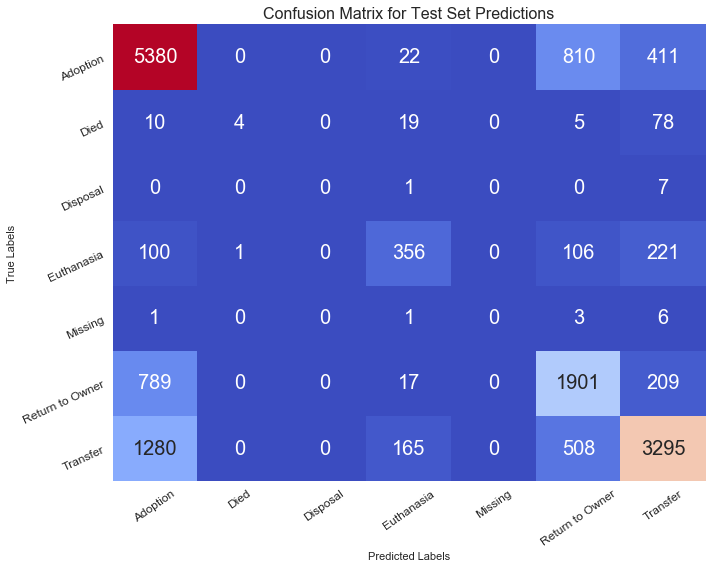

In [173]:
fig = plt.figure(figsize = (10,8))
sns.heatmap(cm, annot = True, fmt = 'd', annot_kws = {'size': 20}, cmap = 'coolwarm', 
           cbar = 0, xticklabels = list(le.classes_), yticklabels = list(le.classes_) )
plt.xticks(rotation = 35, fontsize = 12)
plt.yticks(rotation = 25, fontsize = 12)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set Predictions', fontsize = 16)
plt.tight_layout(h_pad = 5.0, w_pad = 3.0)

Considering the confusion matrix, we can see that the model does well with predicting adoption, return to owner, and transfer outcomes. When the model does not accurately predict adoption, most of the predictions are returned to owner or transferred. The same holds for the converse. When considering the confusion matrix, we want the diagonal elements, which indicate correct prediction, to hold the highest values. Our confusion matrix exhibits this property for most of the outcomes with exception to predicting death, disposal, and missing. This is most likely due to the very low number of occurrences of each outcome and the model was not able to capture features that accurately determined those outcomes. 

In [142]:
feat_imp = pd.DataFrame({'Features':dat.columns.values,'Values':gb_model.feature_importances_})
top_feat = feat_imp.sort_values(by = 'Values').iloc[-10:]
top_feat

,Features,Values
26,Month_Intake_1,0.028307
23,Fixed_0,0.028399
28,Month_Intake_3,0.030661
5,Animal_Type_outcome_0,0.032003
1,Intake_Type_1,0.034448
0,Intake_Type_0,0.038367
2,Intake_Condition_0,0.045723
30,Given_Name,0.048138
24,Fixed_1,0.062480
29,Age_Intake,0.223453


In [143]:
# labels.value_counts()[0]/float(len(labels))

Using Gradient Boosting, we get a 69% accuracy, which is a 5% increase in accuracy from my last analysis using just the outcome data. This is a big improvement and we can actually see from the table above that on the top 10 features that influenced our accuracy, age intake is by far the most important feature in our set. Age intake was not in the outcome set and this is one indicator that the intake dataset contain valuable data that improves prediction accuracy. Another improvement we see from this model compared to the last one is the log loss. The log loss for this model is 0.79 compared to the last model, 0.86. This tells us that we can be more confident in our prediction probabilities from this model. 

### Further Improvements:
I will further work on this dataset as time opens up. Some things I would like to work on are more data visualization, ensemble methods to improve prediction accuracy, try XGBoost with GPU support to improve computation time and accuracy, and to look at precision and recall results. Additionally, I will set up a dashboard using Plotly, which after you produce the plots, Plotly has a point and click tool to easily create dashboards via their UI online. 